In [45]:
import numpy as np
import imageio
import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
from torch.utils.data import DataLoader
import torch
from torch.utils.data import Dataset, DataLoader
import glob
import imageio.v2 as imageio
import numpy as np
from torchvision import transforms
from torchvision import datasets, transforms

In [46]:
# Define a PyTorch Dataset class
class MNISTDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.images = []
        self.labels = []
        self.transform = transform

        NUM_LABELS = 10
        for label in range(NUM_LABELS):
            image_paths = glob.glob(f"{data_dir}/{label}/*.png")
            for image_path in image_paths:
                image = imageio.imread(image_path)
                self.images.append(image)
                self.labels.append(label)  # Using integer labels instead of one-hot

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Convert to tensor and normalize
        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert NumPy image to PIL image
    transforms.Grayscale(num_output_channels=1),  # Ensure grayscale
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize
])

# Define dataset paths
base_path = "C:/Users/ramki/OneDrive/Desktop/DL/MNIST/MNIST"
train_dataset = MNISTDataset(f"{base_path}/Train", transform=transform)
test_dataset = MNISTDataset(f"{base_path}/Test", transform=transform)

# Load dataset using PyTorch DataLoader
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 60000
Test samples: 10000


In [ ]:
class CNN_BatchNorm(nn.Module):
    def __init__(self):
        super(CNN_BatchNorm, self).__init__()

        # Convolutional layers with batch normalization
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(8)

        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)

        self.pool = nn.MaxPool2d(2, 2)

        # Compute correct flattened size dynamically
        with torch.no_grad():
            dummy_input = torch.rand(1, 1, 28, 28)
            dummy_output = self._forward_features(dummy_input)
            flattened_size = dummy_output.view(1, -1).size(1)

        # Fully connected layer
        self.fc = nn.Linear(flattened_size, 10)

    def _forward_features(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        return x  # No flattening here, just feature extraction

    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)  # Flatten before fully connected layer
        x = self.fc(x)
        return x


In [ ]:
class CNN_Dropout(nn.Module):
    def __init__(self):
        super(CNN_Dropout, self).__init__()

        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        # Compute correct flattened size dynamically
        with torch.no_grad():
            dummy_input = torch.rand(1, 1, 28, 28)
            dummy_output = self._forward_features(dummy_input)
            flattened_size = dummy_output.view(1, -1).size(1)

        # Fully connected layer
        self.fc = nn.Linear(flattened_size, 10)

    def _forward_features(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        return x  # No flattening here, just feature extraction

    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)  # Flatten before fully connected layer
        x = self.dropout(x)  # Apply dropout
        x = self.fc(x)
        return x


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        # Compute correct flattened size dynamically
        with torch.no_grad():
            dummy_input = torch.rand(1, 1, 28, 28)
            dummy_output = self._forward_features(dummy_input)
            flattened_size = dummy_output.view(1, -1).size(1)

        # Fully connected layer
        self.fc = nn.Linear(flattened_size, 10)

    def _forward_features(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        return x  # No flattening here, just feature extraction

    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)  # Flatten before fully connected layer
        x = self.fc(x)
        return x


In [53]:
#mini batch
def random_mini_batches(X, Y, batch_size):
    m = X.shape[0]
    mini_batches = []
    permutation = np.random.permutation(m)
    shuffled_X = X[permutation, :]
    shuffled_Y = Y[permutation, :]

    num_batches = m // batch_size
    for k in range(num_batches):
        X_mini = shuffled_X[k * batch_size:(k + 1) * batch_size, :]
        Y_mini = shuffled_Y[k * batch_size:(k + 1) * batch_size, :]
        mini_batches.append((X_mini, Y_mini))

    if m % batch_size != 0:
        X_mini = shuffled_X[num_batches * batch_size:, :]
        Y_mini = shuffled_Y[num_batches * batch_size:, :]
        mini_batches.append((X_mini, Y_mini))

    return mini_batches

In [56]:
#block7
def train_model(model, trainloader, testloader, num_epochs=10, learning_rate=0.001):


    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Lists to store loss and accuracy values
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0

        for images, labels in trainloader:
            images, labels = images, labels

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(trainloader))
        train_accuracies.append(100 * correct_train / total_train)

        # Evaluate model on test set
        model.eval()
        test_loss, correct_test, total_test = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images, labels
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_losses.append(test_loss / len(testloader))
        test_accuracies.append(100 * correct_test / total_test)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, "
              f"Train Acc: {train_accuracies[-1]:.2f}%, Test Acc: {test_accuracies[-1]:.2f}%")

    end_time = time.time()
    print(f"Training time: {end_time - start_time:.2f} seconds")

    return train_losses, test_losses, train_accuracies, test_accuracies

In [57]:
# Instantiate models
cnn_bn = CNN_BatchNorm()
cnn_dropout = CNN_Dropout()
cnn_sgd = CNN()  # Original CNN with SGD optimizer

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizers
optimizer_bn = optim.Adam(cnn_bn.parameters(), lr=0.001)
optimizer_dropout = optim.Adam(cnn_dropout.parameters(), lr=0.001)
optimizer_sgd = optim.SGD(cnn_sgd.parameters(), lr=0.01, momentum=0.9)

# Train all models
train_losses_bn, test_losses_bn, train_accuracies_bn, test_accuracies_bn = train_model(
    cnn_bn, trainloader, testloader
)
train_losses_dropout, test_losses_dropout, train_accuracies_dropout, test_accuracies_dropout = train_model(
    cnn_dropout, trainloader, testloader
)
train_losses_sgd, test_losses_sgd, train_accuracies_sgd, test_accuracies_sgd = train_model(
    cnn_sgd, trainloader, testloader
)


Epoch 1/10, Train Loss: 0.1866, Test Loss: 0.0560, Train Acc: 95.16%, Test Acc: 98.32%
Epoch 2/10, Train Loss: 0.0517, Test Loss: 0.0445, Train Acc: 98.45%, Test Acc: 98.45%
Epoch 3/10, Train Loss: 0.0386, Test Loss: 0.0374, Train Acc: 98.82%, Test Acc: 98.80%
Epoch 4/10, Train Loss: 0.0325, Test Loss: 0.0358, Train Acc: 99.02%, Test Acc: 98.81%
Epoch 5/10, Train Loss: 0.0278, Test Loss: 0.0427, Train Acc: 99.11%, Test Acc: 98.59%
Epoch 6/10, Train Loss: 0.0244, Test Loss: 0.0316, Train Acc: 99.27%, Test Acc: 98.97%
Epoch 7/10, Train Loss: 0.0210, Test Loss: 0.0287, Train Acc: 99.38%, Test Acc: 99.04%
Epoch 8/10, Train Loss: 0.0176, Test Loss: 0.0304, Train Acc: 99.47%, Test Acc: 99.05%
Epoch 9/10, Train Loss: 0.0161, Test Loss: 0.0319, Train Acc: 99.50%, Test Acc: 99.11%
Epoch 10/10, Train Loss: 0.0153, Test Loss: 0.0347, Train Acc: 99.48%, Test Acc: 98.94%
Training time: 232.99 seconds
Epoch 1/10, Train Loss: 0.4042, Test Loss: 0.0912, Train Acc: 87.15%, Test Acc: 97.34%
Epoch 2/10, 

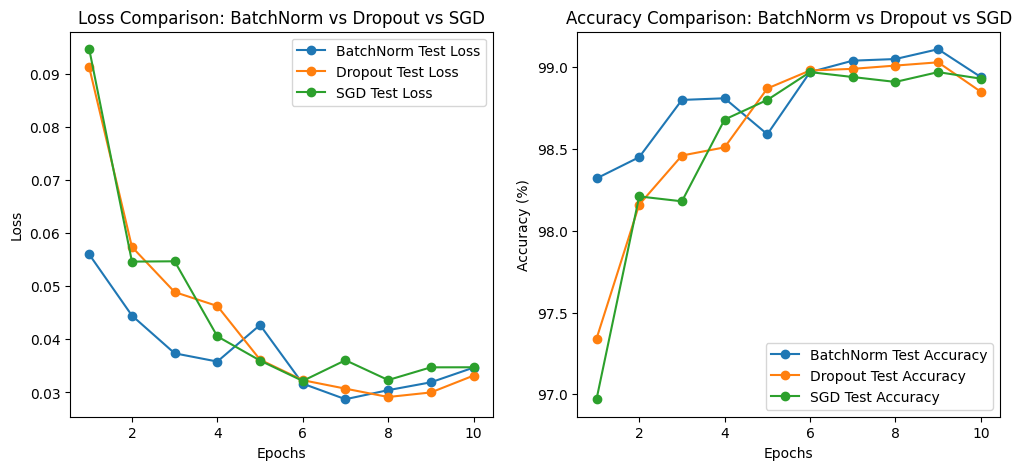

Final test_accuracies_bn: 98.9400
Final test_accuracies_dropout: 98.8500
Final test_accuracies_sgd: 98.9300
Final test_losses_bn: 0.0347
Final test_losses_dropout: 0.0332
Final test_losses_sgd: 0.0347


In [62]:
def plot_model_comparison():
    epochs = range(1, len(train_losses_bn) + 1)

    plt.figure(figsize=(12, 5))

    # Loss Comparison
    plt.subplot(1, 2, 1)
    plt.plot(epochs, test_losses_bn, label='BatchNorm Test Loss', marker='o')
    plt.plot(epochs, test_losses_dropout, label='Dropout Test Loss', marker='o')
    plt.plot(epochs, test_losses_sgd, label='SGD Test Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Comparison: BatchNorm vs Dropout vs SGD')
    plt.legend()

    # Accuracy Comparison
    plt.subplot(1, 2, 2)
    plt.plot(epochs, test_accuracies_bn, label='BatchNorm Test Accuracy', marker='o')
    plt.plot(epochs, test_accuracies_dropout, label='Dropout Test Accuracy', marker='o')
    plt.plot(epochs, test_accuracies_sgd, label='SGD Test Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Comparison: BatchNorm vs Dropout vs SGD')
    plt.legend()

    plt.show()

    print(f"Final test_accuracies_bn: {test_accuracies_bn[-1]:.4f}")
    print(f"Final test_accuracies_dropout: {test_accuracies_dropout[-1]:.4f}")
    print(f"Final test_accuracies_sgd: {test_accuracies_sgd[-1]:.4f}")
    
    print(f"Final test_losses_bn: {test_losses_bn[-1]:.4f}")
    print(f"Final test_losses_dropout: {test_losses_dropout[-1]:.4f}")
    print(f"Final test_losses_sgd: {test_losses_sgd[-1]:.4f}")
    

plot_model_comparison()


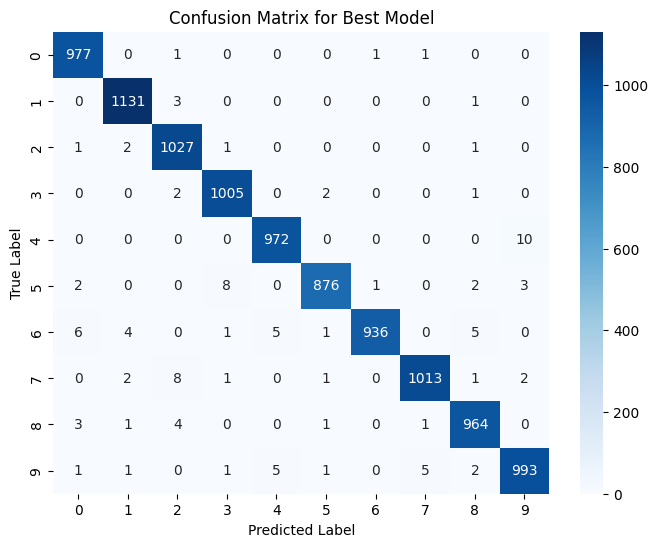

In [60]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Select best performing model (highest test accuracy)
best_model = cnn_bn  # Assume batch normalization performed best

# Get true and predicted labels
y_true, y_pred = [], []

best_model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images, labels
        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Best Model")
plt.show()


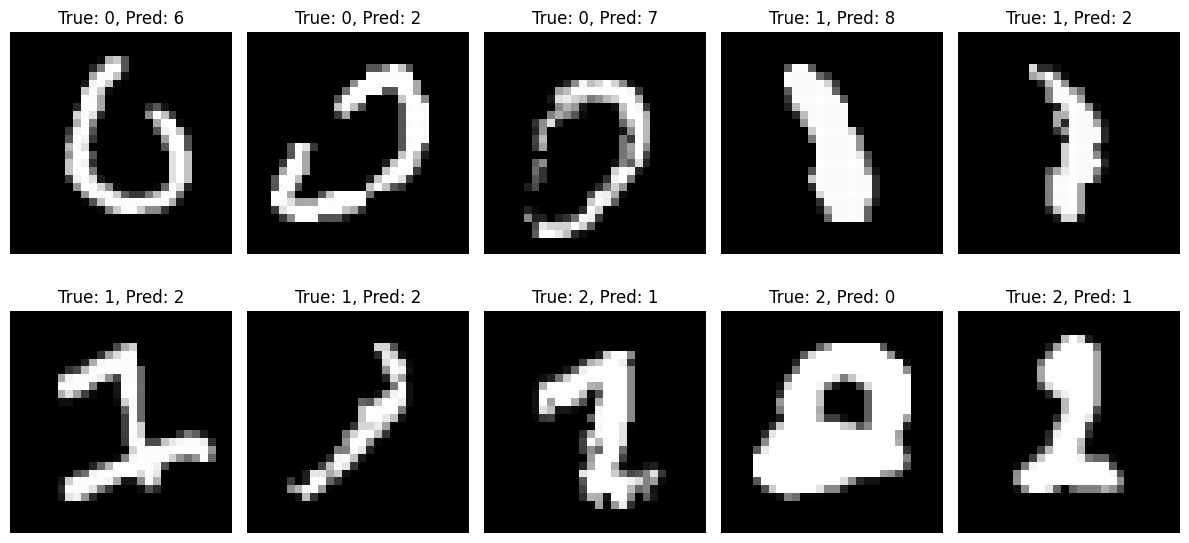

In [61]:
# Extract misclassified images
misclassified = [(img, true, pred) for img, true, pred in zip(testloader.dataset, y_true, y_pred) if true != pred]

# Display 10 misclassified images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

for i, (image_tuple, true_label, predicted_label) in enumerate(misclassified[:10]):
    image, _ = image_tuple  # Extract image tensor from dataset tuple
    axes[i].imshow(image.squeeze(), cmap="gray")  # Correct shape
    axes[i].set_title(f"True: {true_label}, Pred: {predicted_label}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()
